## perguntas a serem respondidas:

- __Quais países recebem maior quantidade de voos de lugares diferentes? (resposta esperada: EUA, Europa)__
- __Quais países voam para maior quantidade de lugares diferentes? (resposta esperada: mesmo que os anteriores)__
- __A rede inicial é uma rede aleatória? (resposta esperada: não)__
- __A rede inicial é livre de escala? Qual o parâmetro? (resposta esperada: sim)__
- A rede inicial é uma rede neutra?
- __A rede inicial possui quantas componentes conexas? Esse número se mantém ao longo do tempo?__
- A rede inicial pode ser separada em grupos/comunidades?
- Qual é a relação entre esses grupos com o passar do tempo?
- Para cada país, a série temporal de número de países que ele pode viajar possui correlação com o número de casos? (resposta esperada: quando um país possui mais casos, ele passe a poder viajar para menos países)
- Quando um país vai remover uma rota de viagem, ele faz de forma aleatória? (resposta esperada: não, ele faz com maior probabilidade para países com maior casos/crescimento de casos)
- É possível identificar o impacto das variantes da África do sul e da Inglaterra na rede?

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import powerlaw
import json
plt.style.use('ggplot')

In [15]:
with open('data/countries.json', 'r') as f:
    countries = json.load(f)
countries_coordinates = pd.read_csv('data/countries_coordinates.csv', sep = ';')
    
with open('data/continents.json', 'r') as f:
    continents = json.load(f)
continents = dict([(x['country'], x['continent']) for x in continents])
    
with open('data/initial_network.np', 'rb') as f:
    initial_network = np.load(f)
    
G_initial = nx.from_numpy_matrix(np.transpose(initial_network), create_using = nx.DiGraph)
G_initial.name = 'initial network'

with open('data/temporal_network.np', 'rb') as f:
    temporal_network = np.load(f)

# Network Analysis

We start looking at the initial network, the network of travels between countries before the coronavirus pandemic. In this network, with data from years before 2015, each country is represented as a node and a link from node $i$ to node $j$ indicates that it is possible to travel by plane from the country $i$ to country $j$.

## Countries with most edges

Daily people travel from many different countries, but are their decision of destination random? Most people travel for tourism, to know the culture of another country, visit beatiful places, thus, the reputation of the country will probabily influence this decision. Besides that, the number of travel routes for a country have also relation with it's economy and the geography of the country.  We now look at what countries make and recieve the most travels. 

PS.: these plots are heavy.

In [16]:
in_degrees = initial_network.sum(axis = 1)
out_degrees = initial_network.sum(axis = 0)
countries_count = {'country': countries, 'in_degree': in_degrees, 'out_degree':out_degrees,
                  'latitude': [], 'longitude': []}
for i, country in enumerate(countries):
    row = countries_coordinates[countries_coordinates.name == country]
    countries_count['latitude'].append(row.latitude.iloc[0])
    countries_count['longitude'].append(row.longitude.iloc[0])


countries_count = pd.DataFrame(countries_count)

In [17]:
px.set_mapbox_access_token(open("data/mapbox_token").read())
df = countries_count
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",     color="in_degree", size="in_degree",
                  size_max=15, zoom=1, title = "Countries In-Degree")
fig.show()

In [18]:
px.set_mapbox_access_token(open("data/mapbox_token").read())
df = countries_count
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",     color="out_degree", size="out_degree",
                  size_max=15, zoom=1, title = "Countries Out-Degree")
fig.show()

We can identify that the countries from the northen hemisphere are the ones that recieve and make the most travels. But we may wonder, what are the countries with biggest variation of in and out degree?

In [19]:
countries_count['delta'] = countries_count.out_degree - countries_count.in_degree
countries_count['delta_plus'] = countries_count.delta - countries_count.delta.min()
px.set_mapbox_access_token(open("data/mapbox_token").read())
df = countries_count

fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="delta", size="delta_plus",
                  size_max=15, zoom=1, title = "Countries Delta (Out-Degree - In-degree)")
fig.show()

We can identify a pattern that most of countries have the same number of in and out edges, without a clear pattern of what countries break this rule.

## Random or Scale Free

A random network is a network where when a new node appears, it will link to random nodes to create new edges, i.e., there is no preference for the creation of new edges. Although, a process like this is not common on real world networks, as it is more common to edges exists based on preferences of the nodes. We can verify numerically if our network fits a random model.

For each pair of nodes in a total of $n(n-1)$ (the order matters), there is a probability $p$ of a directed link from one to the other node, so the expected value of links is $\mathbb{E}[L] = pn(n-1)$, with that, $p = \dfrac{\mathbb{E}[L]}{n(n-1)}$, we can replace the expected value of $L$ with the observed value and have an estimative for $p$.

In [20]:
p = len(G_initial.edges)/ ((len(G_initial.nodes) - 1)*len(G_initial.nodes))
print(f"The estimated probability is: {np.round(p, 3)}")

The estimated probability is: 0.09


With this value, we can simulate a random network with $n$ nodes and compare the distribution of degrees.

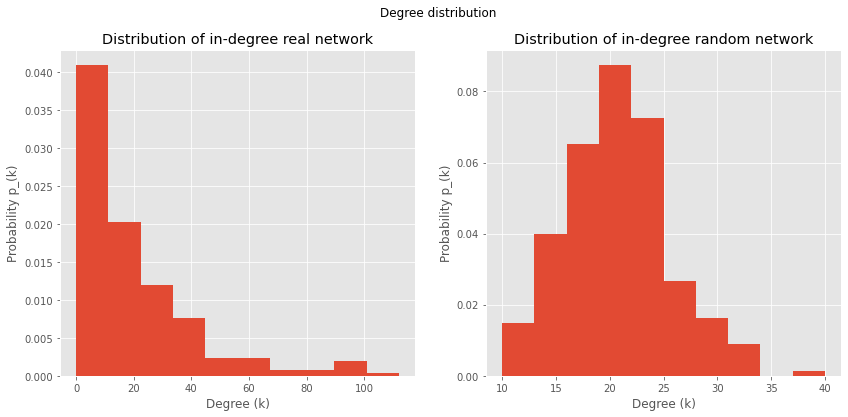

In [40]:
def erdos_renyi(n, p):
    adj = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                r = np.random.random()
                if r < p:
                    adj[i, j] = 1
    return adj

random_network = erdos_renyi(len(G_initial.nodes), p)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].hist(initial_network.sum(axis = 1), density = True)
ax[0].set_title("Distribution of in-degree real network")
ax[1].hist(random_network.sum(axis = 1), density = True)
ax[1].set_title("Distribution of in-degree random network")

for i in range(2):
    ax[i].set_xlabel("Degree (k)")
    ax[i].set_ylabel("Probability p_(k)")

plt.suptitle("Degree distribution")
plt.show()


As we can see, the distribution of in-degree of the real network follows a power law distribution, meaning that many countries have little links and little countries have many links, but in the random network, it follows a binomial distribution, with most countries having the number of in-degree equals to the mean of the in-degree. Now we can verify if our network follows a power law and identify the parameter of the model.

In [38]:
fit_in_degree = powerlaw.Fit(initial_network.sum(axis = 1))
fit_out_degree = powerlaw.Fit(initial_network.sum(axis = 0))

kmax_in_degree = fit_in_degree.xmin*(initial_network.shape[0]**(1/(fit_in_degree.alpha-1)))
kmax_out_degree = fit_out_degree.xmin*(initial_network.shape[0]**(1/(fit_out_degree.alpha-1)))

print("In-degree")
print(f"Gamma: p(k_in) ~= k^{np.round(fit_in_degree.alpha, 3)}")
print(f"Estimated x Observed number of the edges of the biggest node: {kmax_in_degree:.3f}/{initial_network.sum(axis = 1).max():.3f}")

print()
print("Out-degre")
print(f"Gamma: p(k_out) ~= k^{fit_out_degree.alpha:.3f}")
print(f"Estimated x Observed number of the edges of the biggest node: {kmax_out_degree:.3f}/{initial_network.sum(axis = 0).max():.3f}")



In-degree
Gamma: p(k_in) ~= k^2.636
Estimated x Observed number of the edges of the biggest node: 520.935/112.000

Out-degre
Gamma: p(k_out) ~= k^2.634
Estimated x Observed number of the edges of the biggest node: 522.681/115.000


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


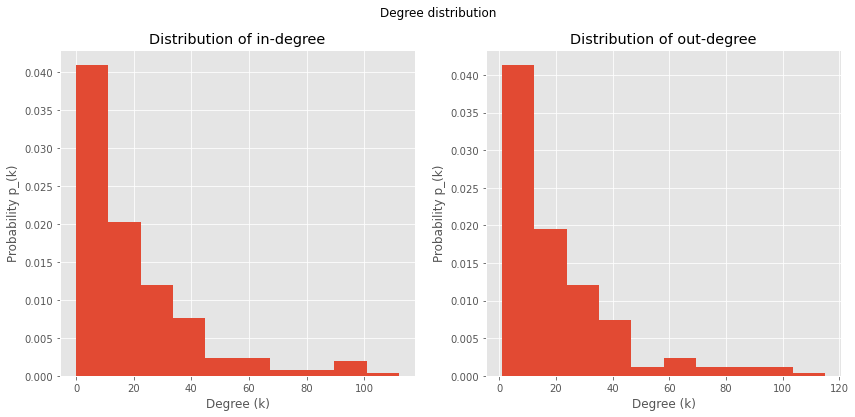

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].hist(initial_network.sum(axis = 1), density = True)
ax[0].set_title("Distribution of in-degree")
ax[1].hist(initial_network.sum(axis = 0), density = True)
ax[1].set_title("Distribution of out-degree")

for i in range(2):
    ax[i].set_xlabel("Degree (k)")
    ax[i].set_ylabel("Probability p_(k)")

plt.suptitle("Degree distribution")
plt.show()


## Assortativity

Another interesting properties of the network is to look at the covariance of degrees, for a node with degree $k$ we want to know if it is more likely to connected with a node of high degree or with a node of low degree. In our situation, this indicates if small airports travels to other small airports or if they are linked to the bigger ones.

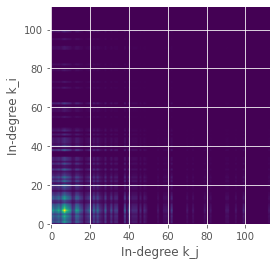

In [55]:
max_in_degree = int(initial_network.sum(axis = 1).max())
degrees_cov = np.zeros((max_in_degree+1, max_in_degree+1))
in_degrees = initial_network.sum(axis = 1)
for i in range(initial_network.shape[0]):
    for j in range(initial_network.shape[0]):
        degree_i = in_degrees[i]
        degree_j = in_degrees[j]
        degrees_cov[int(degree_i), int(degree_j)] += 1
        degrees_cov[int(degree_j), int(degree_i)] += 1

degrees_cov /= initial_network.sum()
plt.imshow(degrees_cov)
plt.ylim((0, max_in_degree))
plt.ylabel("In-degree k_i")
plt.xlabel("In-degree k_j")
plt.show()

## Connected components

A coonected component in a graph is a subset of nodes and edges such that for every two nodes, there is a sequence of edges and nodes such that this two nodes are linked. In our scenario, with we identify more than one connected component, we will find that there is, for example, two different subsets of countries where one country from one subset can't go to any country of the other subset. It is more probable that we found out that there is only one connected component in the initial network, all the countries are linked in some manner, but than we might whant to know, does this connected component remains with the travel restrictions?

A connected component is more easily defined (and calculated) for undirected graphs , and for this interpretation we can ignore the direction of travels to calculate the connected components.

In [3]:
initial_network_undirected = initial_network.copy()
for i in range(initial_network.shape[0]):
    for j in range(initial_network.shape[0]):
        if initial_network[i, j] == 0 and initial_network[j, i] == 0:
            initial_network_undirected[i, j] = 0
        else:
            initial_network_undirected[i, j] = 1

G_undirected = nx.from_numpy_matrix(initial_network_undirected)
print("Number of connected components: " + str(nx.number_connected_components(G_undirected)))

Number of connected components: 1


In [4]:
connected_components_series = []
for t in range(temporal_network.shape[0]):
    temp_undirected = temporal_network[t, :, :].copy()
    for i in range(temp_undirected.shape[0]):
        for j in range(i+1, temp_undirected.shape[0]):
            v = 1
            if temp_undirected[i, j] == 0 and temp_undirected[j, i] == 0:
                v = 0
            temp_undirected[i, j] = v
            temp_undirected[j, i] = v
            
    G_temp_undirected = nx.from_numpy_matrix(temp_undirected)
    connected_components_series.append(nx.number_connected_components(G_temp_undirected))            

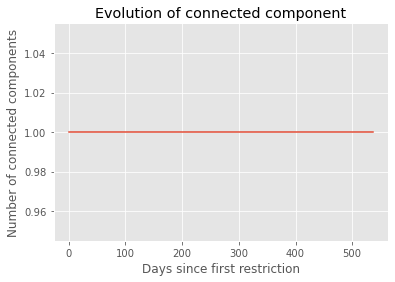

In [29]:
plt.plot(list(range(len(connected_components_series))), connected_components_series)
plt.title("Evolution of connected component")
plt.xlabel("Days since first restriction")
plt.ylabel("Number of connected components")
plt.show()

Evens when the network lost many edges, the number of connected components remains the same, meaning that the world still highly connected.

# Analysis of network evolution

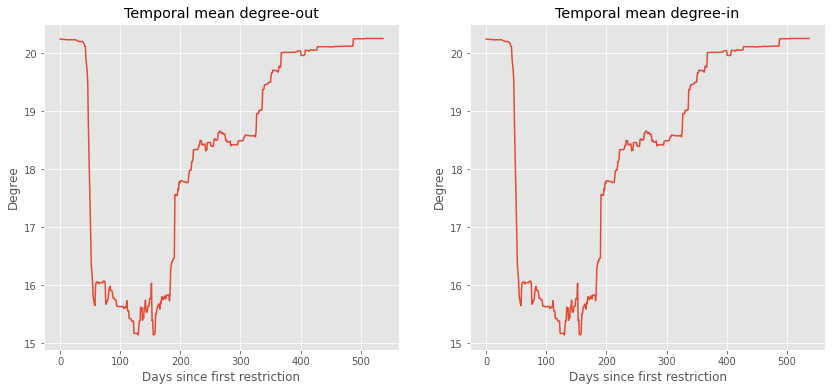

In [7]:
countries_temporal_degree_out_mean = temporal_network.sum(axis = 1).mean(axis = 1)
countries_temporal_degree_in_mean = temporal_network.sum(axis = 2).mean(axis = 1)
n_days = temporal_network.shape[0]
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].plot(list(range(n_days)), countries_temporal_degree_out_mean)
ax[0].set_title("Temporal mean degree-out")
ax[1].plot(list(range(n_days)), countries_temporal_degree_in_mean)
ax[1].set_title("Temporal mean degree-in")

for i in range(2):
    ax[i].set_xlabel("Days since first restriction")
    ax[i].set_ylabel("Degree")
plt.show()

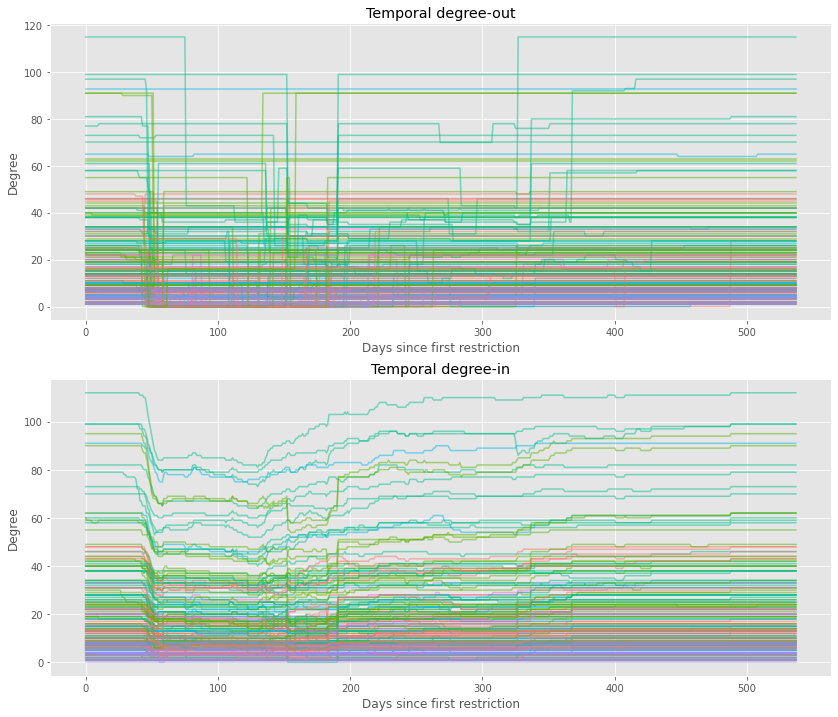

In [8]:
countries_temporal_degree_out = list(zip(countries, temporal_network.sum(axis = 1).transpose()))
countries_temporal_degree_in = list(zip(countries, temporal_network.sum(axis = 2).transpose()))

colors = {'Africa': "#F8766D", "Antartica": "#C59900",
         "Asia": "#5bb300", "Europe": "#00c08d", 
         "North America": "#00b8e5", "Oceania": "#9590ff",
         "South America": "#f763e0"}

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 12))
for i in range(len(countries)):
    country = countries_temporal_degree_out[i][0]
    color = colors[continents[country]]
    ax[0].plot(list(range(n_days)), countries_temporal_degree_out[i][1], c = color, alpha = 0.5)
    country = countries_temporal_degree_in[i][0]
    color = colors[continents[country]]
    ax[1].plot(list(range(n_days)), countries_temporal_degree_in[i][1], c = color, alpha = 0.5)
ax[0].set_title("Temporal degree-out")
ax[1].set_title("Temporal degree-in")



for i in range(2):
    ax[i].set_xlabel("Days since first restriction")
    ax[i].set_ylabel("Degree")
plt.show()

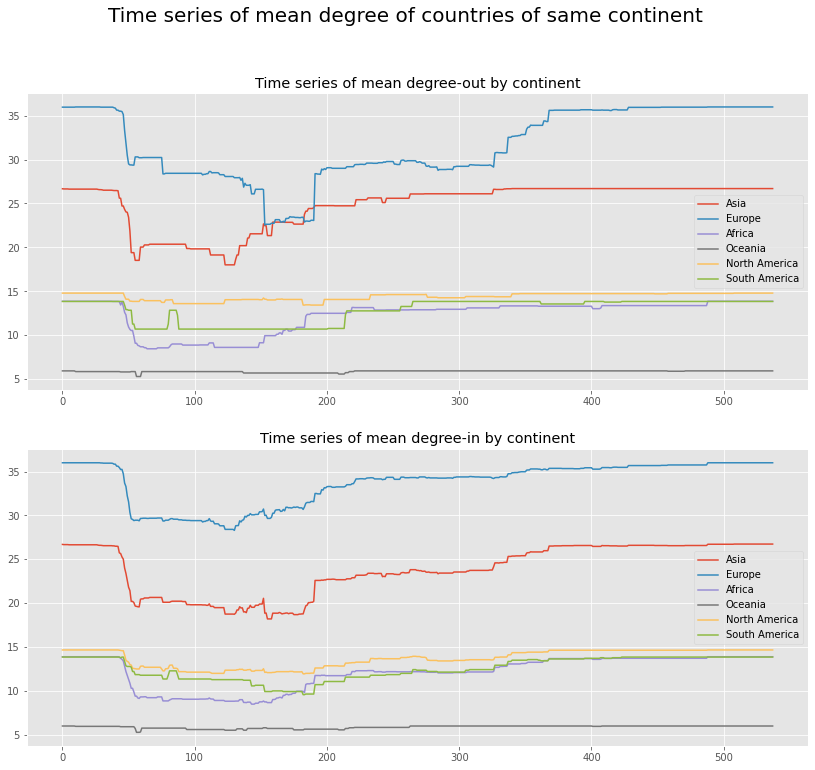

In [9]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 12))

continents_temporal_degrees_out = dict([(v, []) for v in continents.values()])
for country in countries:
    country_i = countries_map[country]
    cont = continents[country]
    continents_temporal_degrees_out[cont].append(temporal_network[:, :, country_i].sum(axis = 1))
for cont in continents_temporal_degrees_out.keys():
    if len(continents_temporal_degrees_out[cont]) > 0:
        continents_temporal_degrees_out[cont] = np.mean(continents_temporal_degrees_out[cont], axis = 0)
        ax[0].plot(list(range(n_days)), continents_temporal_degrees_out[cont], label = cont)
ax[0].legend()


ax[0].set_title("Time series of mean degree-out by continent")

continents_temporal_degrees_in = dict([(v, []) for v in continents.values()])
for country in countries:
    country_i = countries_map[country]
    cont = continents[country]
    continents_temporal_degrees_in[cont].append(temporal_network[:, country_i, :].sum(axis = 1))
for cont in continents_temporal_degrees_in.keys():
    if len(continents_temporal_degrees_in[cont]) > 0:
        continents_temporal_degrees_in[cont] = np.mean(continents_temporal_degrees_in[cont], axis = 0)
        ax[1].plot(list(range(n_days)), continents_temporal_degrees_in[cont], label = cont)
ax[1].legend()
ax[1].set_title("Time series of mean degree-in by continent")

plt.suptitle("Time series of mean degree of countries of same continent", size = 20)
plt.show()

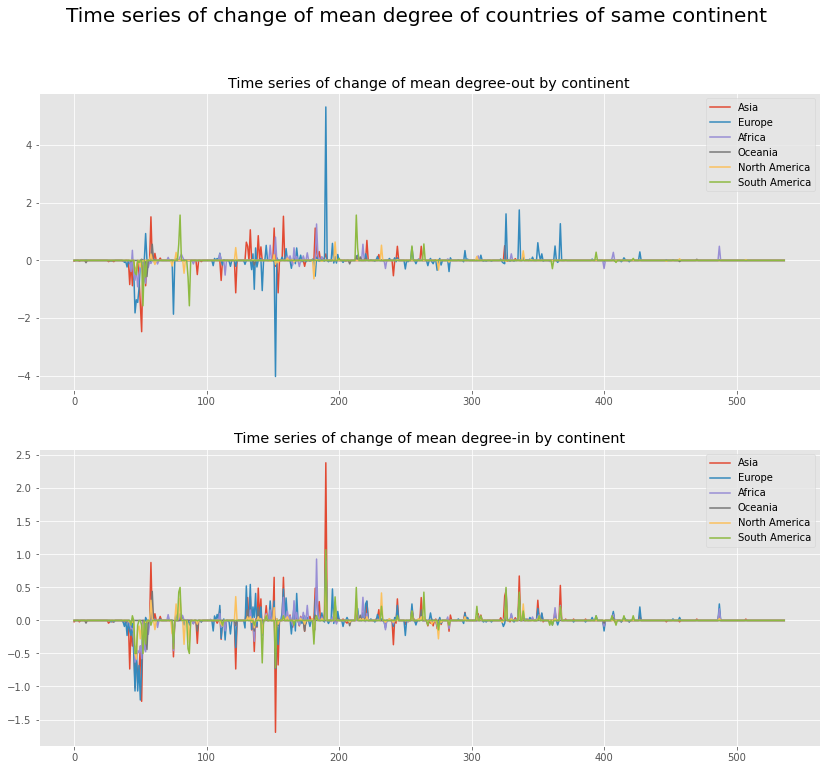

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 12))

for cont in continents_temporal_degrees_out.keys():
    if len(continents_temporal_degrees_out[cont]) > 0:
        ax[0].plot(list(range(n_days - 1)), np.diff(continents_temporal_degrees_out[cont]), label = cont)
ax[0].legend()
ax[0].set_title("Time series of change of mean degree-out by continent")

for cont in continents_temporal_degrees_in.keys():
    if len(continents_temporal_degrees_in[cont]) > 0:
        ax[1].plot(list(range(n_days- 1)), np.diff(continents_temporal_degrees_in[cont]), label = cont)
ax[1].legend()
ax[1].set_title("Time series of change of mean degree-in by continent")

plt.suptitle("Time series of change of mean degree of countries of same continent", size = 20)
plt.show()

## Scale free network

In [39]:
#this cell will probably take time
G = [nx.from_numpy_matrix(temporal_network[i, :, :], create_using = nx.DiGraph) for i in range(n_days)]

In [40]:
max_degree = [temporal_network[i, :, :].sum(axis = 0).max() for i in range(n_days)]

In [41]:
import powerlaw

In [42]:
fit = [powerlaw.Fit(temporal_network[i, :, :].sum(axis = 1), discrete=True) for i in range(n_days)]

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

In [43]:
N = len(countries)
kmax = [f.xmin*(N**(1/(f.alpha-1))) for f in fit]

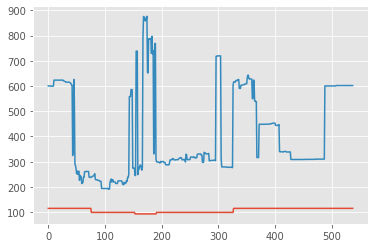

In [44]:
plt.plot(list(range(n_days)), max_degree)
plt.plot(list(range(n_days)), kmax)

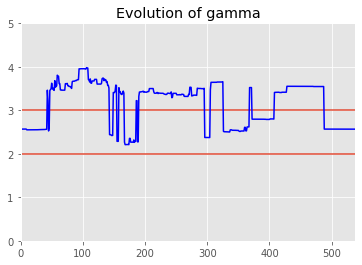

In [45]:
plt.title("Evolution of gamma")
plt.plot(list(range(n_days)), [f.alpha for f in fit], c = "blue")
plt.hlines(2, 0, n_days)
plt.hlines(3, 0, n_days)
plt.ylim((0, 5))
plt.xlim((0, n_days))
plt.show()

In [38]:
components = [nx.number_connected_components(g) for g in G]

NetworkXNotImplemented: not implemented for directed type